In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Patch

In [76]:
columns = ["Timestamp(ms)", "Current(uA)", "D0", "D1"] # Extract only those columns
base_path = r"C:\Users\jzurn\Documents\Studium\HBRS\Bachelorarbeit\Messungen"
filename = "v1_2_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256__noCID_SECP256R1_CERT"

file_path = rf"{base_path}\ppk_csv\{filename}.csv"

version_code = "_".join(filename.split("_")[:2]) 
dtls_version = {"v1_2": "DTLS 1.2", "v1_3": "DTLS 1.3"}.get(version_code)
parts = filename.split("_")
cipher_suite_end_index = parts.index("noCID") if "noCID" in parts else parts.index("CID")
cipher_suite = "_".join(parts[2:cipher_suite_end_index])
curve = parts[-2]
auth_method = parts[-1]
pcap_file = rf"{base_path}\pcap\csv_exports\{filename}.csv"
pcap_df = pd.read_csv(pcap_file)
df = pd.read_csv(file_path, usecols=columns)
memory_log = rf"{base_path}\memory\{filename}.txt"

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)       
pd.set_option("display.max_colwidth", None)  

df["Current(uA)"] = df["Current(uA)"] / 1000  # Convert µA to mA
df = df.rename(columns={"Current(uA)": "Current(mA)"}) # Rename column
df["D0"] = pd.to_numeric(df["D0"], errors="coerce").fillna(0).astype(int) # Converts values to numeric unless non-numeric then NaN (column contains also X as value)
df["D1"] = pd.to_numeric(df["D1"], errors="coerce").fillna(0).astype(int)  # Convert D1 to numeric 

C:\Users\jzurn\AppData\Local\Temp\ipykernel_15620\2619080443.py:16: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, usecols=columns)


In [77]:
# Generate group numbers for D0 and D1
df["CoAP_Interval"] = ((df["D0"] == 1) & (df["D0"].shift(fill_value=0) == 0)).cumsum() * (df["D0"] == 1)
df["Handshakes"] = ((df["D1"] == 1) & (df["D1"].shift(fill_value=0) == 0)).cumsum() * (df["D1"] == 1)

# Calculate statistics for D0
current_coap = df[df["D0"] == 1].groupby("CoAP_Interval").agg(
    Start_Time=("Timestamp(ms)", "first"),
    End_Time=("Timestamp(ms)", "last"),
    Avg_Current=("Current(mA)", "mean"),
    Peak_Current=("Current(mA)", "max")
)

# Add derived columns for D0
current_coap["Time_Diff(s)"] = (current_coap["End_Time"] - current_coap["Start_Time"]) / 1000
current_coap["Total_Charge(mC)"] = current_coap["Avg_Current"] * current_coap["Time_Diff(s)"]

# Calculate statistics for D1
current_handshakes = df[df["D1"] == 1].groupby("Handshakes").agg(
    Start_Time=("Timestamp(ms)", "first"),
    End_Time=("Timestamp(ms)", "last"),
    Avg_Current=("Current(mA)", "mean"),
    Peak_Current=("Current(mA)", "max")
)

# Add derived columns for D1
current_handshakes["Time_Diff(s)"] = (current_handshakes["End_Time"] - current_handshakes["Start_Time"]) / 1000
current_handshakes["Total_Charge(mC)"] = current_handshakes["Avg_Current"] * current_handshakes["Time_Diff(s)"]

current_handshakes = current_handshakes.reset_index()
current_handshakes["Handshakes"] = current_handshakes["Handshakes"] - 1

# Reset index for D1 and rename the group column
#current_handshakes = current_handshakes.reset_index().rename(columns={"GPIO_high_D1": "Group_coap"})
current_coap=current_coap.round(2)
current_handshakes=current_handshakes.round(2)

current_coap["Bytes_Sent"] = 0
current_coap["Bytes_Received"] = 0

current_handshakes["Bytes_Sent"] = 0
current_handshakes["Bytes_Received"] = 0

In [78]:
# Process handshakes based on the DTLS version
if version_code == "v1_2":
    print("Processing DTLS 1.2 Handshakes...")

    for group in current_handshakes["Handshakes"]:
        # Identify the start of the handshake (first "Client Hello")
        handshake_start = pcap_df[
            (pcap_df["Info"].str.contains("Client Hello"))
        ].index[0]

        # Identify the end of the handshake (second "Change Cipher Spec")
        handshake_end = pcap_df[
            (pcap_df["Info"].str.contains("Change Cipher Spec"))
        ].index[1]  # Directly select the second occurrence

        # Extract packets belonging to this handshake
        handshake_packets = pcap_df.loc[handshake_start:handshake_end]

        # Calculate Bytes Sent and Bytes Received
        bytes_sent = handshake_packets[handshake_packets["Source"].isin(["10.1.1.2", "10.1.1.3"])]["Length"].sum()
        bytes_received = handshake_packets[handshake_packets["Source"] == "10.1.1.10"]["Length"].sum()

        # Update current_handshakes DataFrame
        current_handshakes.loc[current_handshakes["Handshakes"] == group, "Bytes_Sent"] = bytes_sent
        current_handshakes.loc[current_handshakes["Handshakes"] == group, "Bytes_Received"] = bytes_received
    print(current_handshakes)

Processing DTLS 1.2 Handshakes...
   Handshakes  Start_Time  End_Time  Avg_Current  Peak_Current  Time_Diff(s)  Total_Charge(mC)  Bytes_Sent  Bytes_Received
0           0      3181.7   10175.7        13.29         74.51          6.99             92.94        1323            1370
1           1     33700.7   40657.9        12.79         75.19          6.96             88.99        1323            1370
2           2     64154.8   71214.0        13.07         72.79          7.06             92.23        1323            1370
3           3     94651.3  101697.0        13.67         67.86          7.05             96.28        1323            1370
4           4    125125.5  132173.1        12.55         67.04          7.05             88.45        1323            1370
5           5    155640.2  162732.2        12.72         78.18          7.09             90.21        1323            1370
6           6    186165.6  193137.2        12.57         66.95          6.97             87.63        132

In [79]:
# Process DTLS 1.3 handshakes
if version_code == "v1_3":
    print("Processing DTLS 1.3 Handshakes...")

    # Identify all Client Hello messages
    client_hello_indices = pcap_df[
        (pcap_df["Info"].str.contains("Client Hello"))
    ].index

    # Keep every other Client Hello
    filtered_client_hello_indices = client_hello_indices[::2]

    # Populate handshake_end_indices (first packet of length 71 or 72 after the start index)
    handshake_end_indices = []
    for start_index in filtered_client_hello_indices:
        end_index_candidates = pcap_df[
            ((pcap_df["Length"] == 71) | (pcap_df["Length"] == 72)) & 
            (pcap_df.index > start_index)
        ].index

        # Append the first matching end index
        if not end_index_candidates.empty:
            handshake_end_indices.append(end_index_candidates[0])

    print("Filtered Client Hello Indices:", filtered_client_hello_indices.tolist())
    print("Handshake End Indices:", handshake_end_indices)

    # Ensure the lengths match
    if len(filtered_client_hello_indices) != len(handshake_end_indices):
        print("Error: Mismatch between start and end indices!")
        raise ValueError("Start and end indices must have the same length.")

    # Initialize lists to store sent and received bytes for all handshakes
    bytes_sent_all_handshakes = []
    bytes_received_all_handshakes = []

    # Loop through each handshake group
    for group, (start_index, end_index) in enumerate(zip(filtered_client_hello_indices, handshake_end_indices)):

        # Extract packets for the current handshake
        handshake_packets = pcap_df.loc[start_index:end_index - 1]

        # Dynamically determine the source for sent packets
        if not handshake_packets.empty:
            dynamic_source = handshake_packets.iloc[0]["Source"]
        else:
            print(f"Warning: Handshake {group} has no packets!")
            dynamic_source = None

        # Calculate Bytes Sent
        sent_packets = handshake_packets[handshake_packets["Source"] == dynamic_source] if dynamic_source else pd.DataFrame()
        bytes_sent = sent_packets["Length"].sum()

        # Calculate Bytes Received
        received_packets = handshake_packets[handshake_packets["Source"] == "10.1.1.10"]
        bytes_received = received_packets["Length"].sum()

        # Append the results to the lists
        bytes_sent_all_handshakes.append(bytes_sent)
        bytes_received_all_handshakes.append(bytes_received)

    # Add the results to the current_handshakes DataFrame
    current_handshakes["Bytes_Sent"] = bytes_sent_all_handshakes
    current_handshakes["Bytes_Received"] = bytes_received_all_handshakes

    # Display the updated DataFrame
    print("\nUpdated current_handshakes DataFrame:")
    print(current_handshakes)


In [80]:
with open(memory_log, "r") as file:
    lines = file.readlines()

# Normalize spaces and filter lines containing "peak bytes"
normalized_lines = [" ".join(line.split()) for line in lines]
peak_lines = [line for line in normalized_lines if "peak bytes" in line.lower()]

# Extract numeric values for peak bytes
peak_values = [int(line.split("=")[-1].strip()) for line in peak_lines]
print(f"Extracted Peak Values (Bytes): {peak_values}")

# Update DataFrames
# Assign first value to current_handshakes
current_handshakes.loc[0, "Peak Memory(Bytes)"] = peak_values[0]

# Assign up to 20 consecutive values to current_coap, starting from index 1
for i, value in enumerate(peak_values[1:21], start=1):  # Start with index 1
    current_coap.loc[i, "Peak Memory(Bytes)"] = value

Extracted Peak Values (Bytes): [34164, 1916, 1916, 1916, 37820, 1916, 1916, 37820, 1916, 1916, 37820, 1916, 1916, 37821, 1916, 1916, 37821, 1916, 1916, 37819, 1916, 10254]


In [81]:
output_file = rf"{base_path}\python_adjusted\combined_data\coap_cycles\{filename}_cycles.csv"
current_coap.to_csv(output_file, index=False)

output_file = rf"{base_path}\python_adjusted\combined_data\handshakes\{filename}_handshakes.csv"
current_handshakes.to_csv(output_file, index=False)

print(current_handshakes)
print("\n")
print(current_coap)

   Handshakes  Start_Time  End_Time  Avg_Current  Peak_Current  Time_Diff(s)  Total_Charge(mC)  Bytes_Sent  Bytes_Received  Peak Memory(Bytes)
0           0      3181.7   10175.7        13.29         74.51          6.99             92.94        1323            1370             34164.0
1           1     33700.7   40657.9        12.79         75.19          6.96             88.99        1323            1370                 NaN
2           2     64154.8   71214.0        13.07         72.79          7.06             92.23        1323            1370                 NaN
3           3     94651.3  101697.0        13.67         67.86          7.05             96.28        1323            1370                 NaN
4           4    125125.5  132173.1        12.55         67.04          7.05             88.45        1323            1370                 NaN
5           5    155640.2  162732.2        12.72         78.18          7.09             90.21        1323            1370                 NaN

Saved plot to C:\Users\jzurn\Documents\Studium\HBRS\Bachelorarbeit\Messungen\python_adjusted\plots\coap_cycles\v1_2_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256__noCID_SECP256R1_CERT_cycles.png


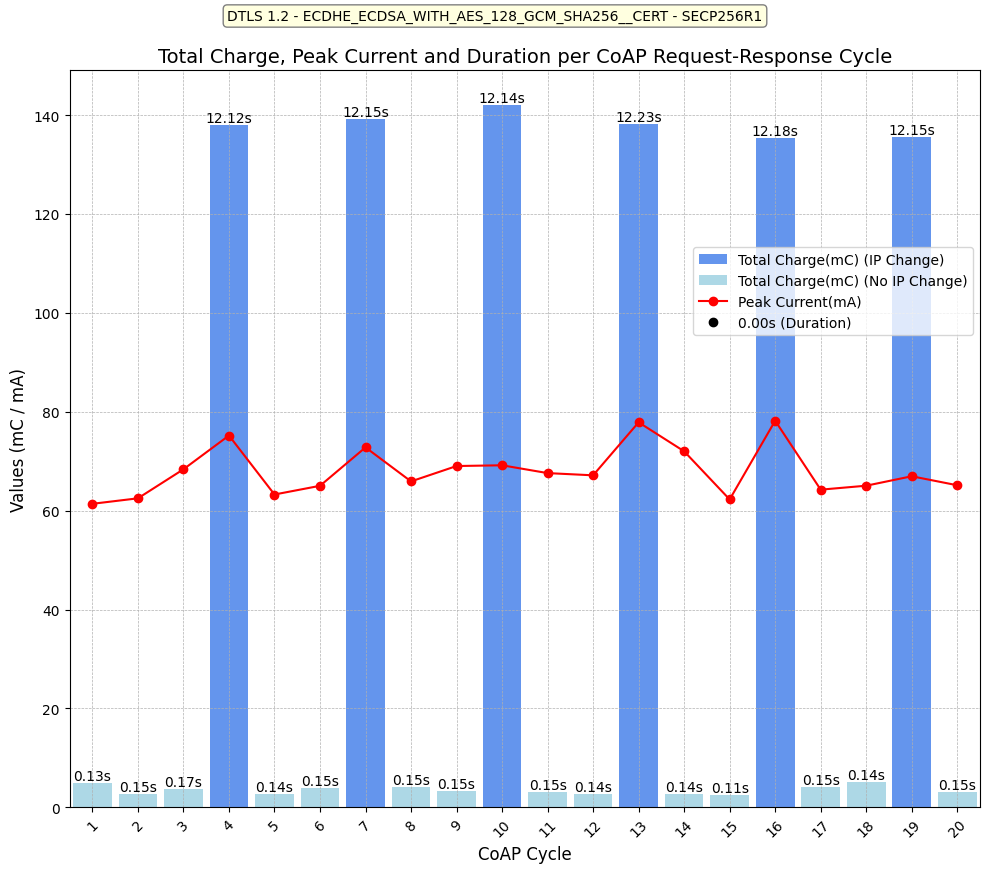

In [82]:
# Plot Total Charge (mC) and Peak Current (mA) for D0 groups
plt.figure(figsize=(10, 9))  # Set figure size
plt.xlim(current_coap.index[0] - 0.5, current_coap.index[-1] + 0.5)

xlabel_text = f"CoAP Cycles : {dtls_version} - {cipher_suite} - {auth_method} - {curve}"
special_indices = [4, 7, 10, 13, 16, 19]

bars_coap = plt.bar(
    current_coap.index, 
    current_coap["Total_Charge(mC)"], 
    color=["cornflowerblue" if idx in special_indices else "lightblue" for idx in current_coap.index],
    label="Total Charge (mC)",
    width=0.85,  # Reduce bar width 
)

legend_elements = [
    Patch(facecolor="cornflowerblue", edgecolor="none", label="Total Charge(mC) (IP Change)"),
    Patch(facecolor="lightblue", edgecolor="none", label="Total Charge(mC) (No IP Change)"),
    mlines.Line2D([], [], color="red", marker="o", label="Peak Current(mA)"),
    mlines.Line2D([], [], color="black", marker="o", linestyle="None", label="0.00s (Duration)")
]

# Update the legend to include this distinction
plt.legend(
    handles=legend_elements,
    fontsize=10,
    loc="center right",
    bbox_to_anchor=(1, 0.7)
)

plt.plot(
    current_coap.index, 
    current_coap["Peak_Current"], 
    color="red", 
    marker="o", 
    label="Peak Current(mA)"
)

for bar, time_diff in zip(bars_coap, current_coap["Time_Diff(s)"]):  # Assuming 'Time_Diff(s)' exists
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        bar.get_height(),               # Y-coordinate (above the bar)
        f"{time_diff:.2f}s",                 # Format duration as seconds
        ha="center",                        # Horizontal alignment
        va="bottom",                        # Vertical alignment
        fontsize=10,
        #bbox=dict(boxstyle="round,pad=0.1", edgecolor="darkgreen", facecolor="lightyellow")  # Highlighted text box
    )
    
cipher_info = f"{dtls_version} - {cipher_suite}_{auth_method} - {curve}"
top_y = current_coap["Total_Charge(mC)"].max()  # Find the highest value in the bar data
text_y = top_y + (0.1 * top_y)  # Add a margin above the highest bar

plt.text(         
    0.5, 0.95,
    cipher_info,
    fontsize=10,
    ha="center",  # Align text to the right
    va="bottom", # Align text to the bottom
    transform=plt.gcf().transFigure,  # Use figure-relative positioning
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="lightyellow")
)

# Add labels, title, and legend for D0
plt.xlabel("CoAP Cycle", fontsize=12)
plt.ylabel("Values (mC / mA)", fontsize=12)
plt.title("Total Charge, Peak Current and Duration per CoAP Request-Response Cycle", fontsize=14)

# Customize grid and ticks
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(current_coap.index, rotation=45, fontsize=10)
plt.tight_layout()

plot_file = rf"{base_path}\python_adjusted\plots\coap_cycles\{filename}_cycles.png"
plt.savefig(plot_file)
print(f"Saved plot to {plot_file}")
# Show the plot for D0
plt.show()

Saved plot to C:\Users\jzurn\Documents\Studium\HBRS\Bachelorarbeit\Messungen\python_adjusted\plots\handshakes\v1_2_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256__noCID_SECP256R1_CERT_handshake.png


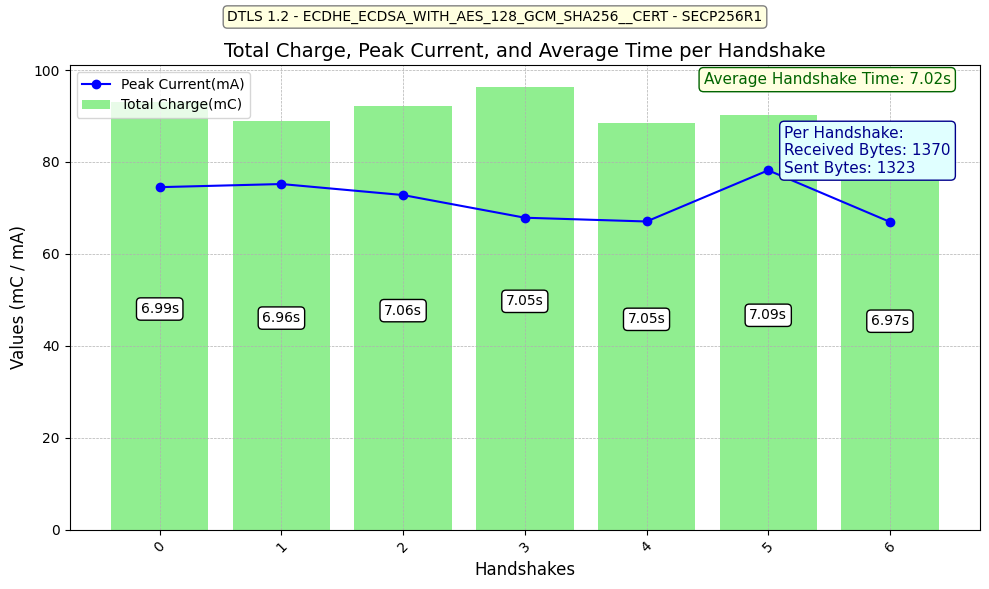

In [83]:

average_handshake_time = current_handshakes["Time_Diff(s)"].mean()
max_bar_height = current_handshakes["Total_Charge(mC)"].max()

# Plot Total Charge (mC) and Peak Current (mA) for D1 groups
plt.figure(figsize=(10, 6))  # Set figure size

# Assign the bar plot to a variable for accessing bar properties
bars_handshakes = plt.bar(
    current_handshakes.index, 
    current_handshakes["Total_Charge(mC)"], 
    color="lightgreen", 
    label="Total Charge(mC)"
)

# Plot Peak Current as a line
plt.plot(
    current_handshakes.index, 
    current_handshakes["Peak_Current"], 
    color="blue", 
    marker="o", 
    label="Peak Current(mA)"
)

# Add time labels on top of the bars
for bar, time_diff in zip(bars_handshakes, current_handshakes["Time_Diff(s)"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        bar.get_height() /2,            # Y-coordinate (above the bar)
        f"{time_diff:.2f}s",               # Format time as seconds
        ha="center",                       # Horizontal alignment
        va="bottom",                       # Vertical alignment
        fontsize=10,                       # Font size
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")  # Optional background

    )
    
# Display the overall average handshake time closer to the bar heights
plt.text(
    len(current_handshakes) - 0.5,  # X-coordinate near the rightmost bar
    max_bar_height,             # Y-coordinate slightly above the tallest bar
    f"Average Handshake Time: {average_handshake_time:.2f}s",  # Text to display
    fontsize=11,
    color="darkgreen",
    ha="right",  # Align text to the right
    va="bottom", # Align text to the bottom of the text box
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="darkgreen", facecolor="lightyellow")  # Highlighted text box
)

average_received_bytes = current_handshakes["Bytes_Received"].mean()
average_sent_bytes = current_handshakes["Bytes_Sent"].mean()

# Display the per-handshake received and sent bytes
plt.text(
    len(current_handshakes) - 0.5,  # X-coordinate near the rightmost bar
    max_bar_height * 0.8,  # Y-coordinate slightly below the first box
    f"Per Handshake:\nReceived Bytes: {int(average_received_bytes)}\nSent Bytes: {int(average_sent_bytes)}",  # Format as integers
    fontsize=11,
    color="darkblue",
    ha="right",  # Align text to the right
    va="bottom",  # Align text to the bottom of the text box
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="darkblue", facecolor="lightcyan"),  # Highlighted text box
    multialignment="left"
)

plt.text(         
    0.5, 0.95,
    cipher_info,
    fontsize=10,
    ha="center",  # Align text to the right
    va="bottom", # Align text to the bottom
    transform=plt.gcf().transFigure,  # Use figure-relative positioning
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="lightyellow")
)

# Add labels, title, and legend
xlabel_text = rf"Handshakes : {dtls_version} - {cipher_suite}_{auth_method} - {curve}"
plt.xlabel("Handshakes", fontsize=12)
plt.ylabel("Values (mC / mA)", fontsize=12)
plt.title("Total Charge, Peak Current, and Average Time per Handshake", fontsize=14)
plt.legend()

# Customize grid and ticks
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(current_handshakes.index, rotation=45, fontsize=10)
plt.tight_layout()
plot_file = rf"{base_path}\python_adjusted\plots\handshakes\{filename}_handshake.png"
plt.savefig(plot_file)
print(f"Saved plot to {plot_file}")

# Show the plot for D1
plt.show()